In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.models import load_model
from keras import backend as K

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = load_model('CIFAR-10.h5')
model.summary()

In [38]:
# The local path to our target image
img_path = 'test_images/image1.jpg'

# `img` is a PIL image of size 32x32
img = image.load_img(img_path, target_size=(32, 32))

# `x` is a float32 Numpy array of shape (32, 32, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 32, 32, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = x/255

arr_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
preds = model.predict(x)

arr_combine = []

# get the list
for category, prediction in zip(arr_cifar, preds[0]):
    arr_tmp = [category, prediction]
    arr_combine.append(arr_tmp )  

# sort and print the list based on the predicted percentage
sorted_list = sorted(arr_combine, key=lambda x:x[1], reverse=True)
for s in sorted_list:
    print(s)

['airplane', 0.8474136]
['bird', 0.098263204]
['deer', 0.03206454]
['cat', 0.008991596]
['horse', 0.0061160545]
['dog', 0.004392317]
['frog', 0.0026079966]
['ship', 0.00012056919]
['truck', 2.0477857e-05]
['automobile', 9.723165e-06]


In [29]:
np.argmax(preds[0])

0

In [32]:
# the entry in the prediction vector
airplane_output = model.output[:, 0]

# the last convolutional layer in the model
last_conv_layer = model.get_layer('conv2d_12')

# This is the gradient of the "african elephant" class with regard to
grads = K.gradients(airplane_output, last_conv_layer.output)[0]

# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(32):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

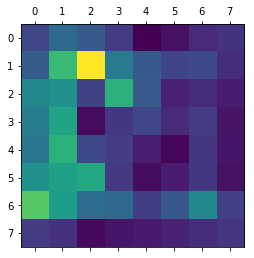

In [33]:
# visualize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [35]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('bird_cam2.png', superimposed_img)

True